# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

# Define Constants

In [5]:
# CONSTANTS
MAX_LASERS = 197

# Load Data

In [6]:
df = pd.read_parquet("./data/train_regression.parquet")
data = df.to_numpy(dtype=np.float32)

X_train_32_raw = data[:, :-1]
Y_train_32_raw = data[:, -1]

Z_raw = pd.read_parquet("./data/test_regression.parquet")
Z_32_raw = df.to_numpy(dtype=np.float32)

X_test_32_raw = Z_32_raw[:,:-1]
Y_test_32_raw = Z_32_raw[:, -1]

## Load pre-saved Normalized Data

In [7]:
train_normalized = np.load("./data/train_data_normalized.npy")
test_normalized = np.load("./data/test_data_normalized.npy")

X_train_norm  = train_normalized[:, :-1]
Y_train_norm = train_normalized[:, -1]
X_test_norm = test_normalized[:, :-1]
Y_test_norm = test_normalized[:, -1]

Z_raw = pd.read_parquet("./data/test_regression.parquet")
X_test_raw = Z_raw.iloc[:,:-1]
Y_test_raw = Z_raw.iloc[:, -1]
X_test_raw = np.array(X_test_raw, dtype=np.float64)
Y_test_raw = np.array(Y_test_raw, dtype=np.float64)


# Helper Functions

In [8]:
# Normalize Data
def normalize(X_train, X_test, Y_train):
  X_mean = np.mean(X_train, axis=0)
  X_std = np.std(X_train, axis=0)

  X_train_norm = np.array(X_train)
  X_test_norm = np.array(X_test)
  for i in range(len(X_mean)):
    X_train_norm[:, i] = (X_train[:, i] - X_mean[i]) / X_std[i]
    X_test_norm[:, i] = (X_test[:, i] - X_mean[i]) / X_std[i]

  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  Y_train_norm = (Y_train - Y_mean) / Y_std

  return X_train_norm, X_test_norm, Y_train_norm

# Normalize a single data set
def normalize_one(X):
  X_mean = np.mean(X, axis=0)
  X_std = np.std(X, axis=0)

  X_norm = np.array(X)
  for i in range(len(X_mean)):
    X_norm[:, i] = (X[:, i] - X_mean[i]) / X_std[i]

  return X_norm

# Denormalize Y_test based on Y_train
def denormalize(Y_train, Y_test):
  Y_mean = np.mean(Y_train)
  Y_std = np.std(Y_train)
  return Y_test * Y_std + Y_mean

def showWeightPlot(model, abs=False):
    coef = model.coef_
    if abs:
      coefs = np.abs(model.coef_)
    plt.bar([x for x in range(len(coef))], coef)
    plt.show()

def trainSubset(X, Y, removed, model, metric, **kwargs):
    remaining = [i for i in range(MAX_LASERS) if i not in removed]
    return train_with_CV(X[:, remaining], Y, model, metric, **kwargs)

def calcMSE(model, X, Y_true, Y_train):
    Y_pred = model.predict(X)
    y_pred = Y_pred * Y_train.mean(axis=0) + Y_train.std(axis=0)
    return mean_squared_error(Y_true, Y_pred)

# Plot predicted vs actual graph
def plot_pred_v_actual(Y_pred, Y_actual):
  plt.scatter(Y_actual, Y_pred, s=0.1, color='blue')

  xs = np.linspace(1, 200)
  plt.plot(xs, xs, color='red')

  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title("Predicted vs. Actual Graph")
  plt.show()

# Train with cross-validation
def train_with_CV(X, Y, model, metric, folds=5, norm=False, graph=True, **kwargs):
  metrics = []
  kf = KFold(n_splits=folds)
  for train, test in kf.split(X):
    x_train, y_train = X[train], Y[train]
    x_test, Y_test = X[test], Y[test]
    if norm:
      X_train, X_test, Y_train = normalize(x_train, x_test, y_train)
    else:
      X_train, X_test, Y_train = x_train, x_test, y_train

    reg = model(**kwargs)
    reg.fit(X_train, Y_train)

    Y_pred = reg.predict(X_test)
    if norm:
      Y_pred = denormalize(y_train, Y_pred)
    m = metric(Y_test, Y_pred)
    metrics.append(m)
  # Take last fold and graph its result on test split and last seen regression
  if graph:
    plot_pred_v_actual(Y_pred, Y_test)
  return np.mean(metrics), reg

# Train just by splitting up the data into train/test
def train_with_split(X, Y, model, metric, split_size=0.2, norm=False, graph=True, **kwargs):
  x_train_split, x_test_split, y_train_split, Y_test_split = train_test_split(X, Y, test_size=0.2)
  if norm:
    X_train_split, X_test_split, Y_train_split = normalize(x_train_split, x_test_split, y_train_split)
  else:
    X_train_split, X_test_split, Y_train_split = x_train_split, x_test_split, y_train_split

  reg = model(**kwargs)
  reg.fit(X_train_split, Y_train_split)

  Y_pred = reg.predict(X_test_split)
  if norm:
    Y_pred = denormalize(y_train_split, Y_pred)
  if graph:
    plot_pred_v_actual(Y_pred, Y_test_split)
  return metric(Y_test_split, Y_pred), reg

# Beam Searching

### Baseline Testing
Simple linear regression

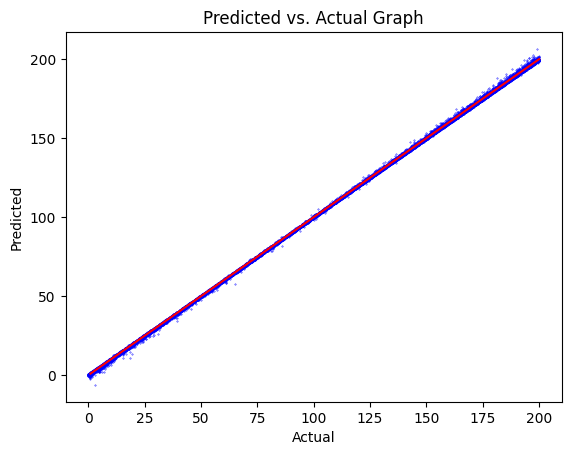

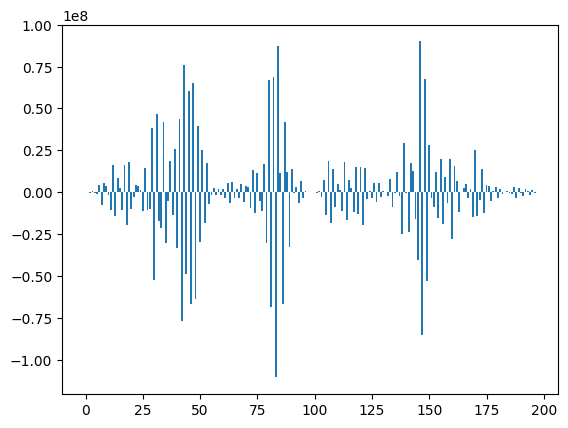

MSE:  0.24856790796160758


In [310]:
base_mse, base_model = train_with_CV(X_train_norm, Y_train_norm, LinearRegression, mean_squared_error)
showWeightPlot(base_model)
print("MSE: ", base_mse)


### Logic for Beam Searching
Warning: This will take a very long time. ~24 hours on a MacBookPro M1 Pro

In [9]:
def trainSubset(X, Y, removed, model, metric, **kwargs):
    remaining = [i for i in range(MAX_LASERS) if i not in removed]
    return train_with_CV(X[:, remaining], Y, model, metric, **kwargs)

In [ ]:
from time import time

lasers = set([i for i in range(MAX_LASERS)])
removed_lasers = []
errors = []
models = []

for i in range(MAX_LASERS - 1):
    start1 = time()
    print("Starting Round:", i+1, "/", MAX_LASERS)
    best_mse = float('inf')
    best_reg = None
    removed_index = -1
    count = 1
    for j in lasers:
        start2 = time()
        print("\tPerforming regression", count, "/", len(lasers))
        count += 1
        curr_mse, curr_reg = trainSubset(X_train_norm, Y_train_norm, removed_lasers +  [j],LinearRegression, mean_squared_error, graph=False)
        if curr_mse < best_mse:
            best_mse, best_reg = curr_mse, curr_reg
            removed_index = j
        end2 = time()
        print("\t\t", end2 - start2, "s")
    end1 = time()
    print("\t", end1 - start1, "s")

    removed_lasers.append(removed_index)
    lasers.remove(removed_index)
    errors.append(best_mse)
    models.append(deepcopy(curr_reg))

# Results

## Removed Lasers
### Loading pre-saved results

In [10]:
removed_lasers = np.load("removed_lasers.npy")
errors = np.load("errors.npy")

# Saving the Results

In [102]:
import pickle
from joblib import dump, load

In [50]:
np.save('errors.npy', errors)
np.save('removed_lasers.npy', removed_lasers)

In [ ]:
for i in range(1, 198):
    print(i)
    dump(models[i-1], 'linear_reg_models/removed_' + str(i) + '.joblib') 

## Regenerating the models based on the removed lasers because there was an error
### For some reason, saving deepcopies of the models doesn't work well. This step is recommended if specific models wish to be revisited.

In [69]:
models_list = []
errors = []
for i in range(MAX_LASERS):
    res, reg = trainSubset(X_train_norm, Y_train_norm, removed_lasers[:i], LinearRegression, mean_squared_error, graph=False)
    models_list.append(deepcopy(reg))
    errors.append(res)

Save the models

In [68]:
for i in range(0, MAX_LASERS):
    dump(models_list[i], 'linear_reg_models/removed_' + str(i) + '.joblib')
np.save("errors.npy", errors)

In [243]:
def save_models(models, filename):
    for i in range(0, len(models)):
        removed = MAX_LASERS - len(models[i].coef_)
        dump(models_list[i], filename + "_removed_" + str(removed) + '.joblib')


Load the Models

In [111]:
models_list = []
for i in range(0, MAX_LASERS):
    loaded_model = load("linear_reg_models/removed_"  + str(i) +".joblib")
    models_list.append(deepcopy(loaded_model))
errors = np.load("errors.npy")

In [149]:
def load_models(file_prefixes):
    models = []
    for file in file_prefixes:
        loaded_model = load(file +".joblib")
        models.append(deepcopy(loaded_model))


Execute this if necessary
i.e. if len(model_lists) and len(errors) is 196 instead of 197

In [116]:
if len(models_list) != MAX_LASERS:
    models_list = [base_model] + list(models_list)
if len(errors) != MAX_LASERS:
    errors = [base_mse] + list(errors)

# Error Graphs

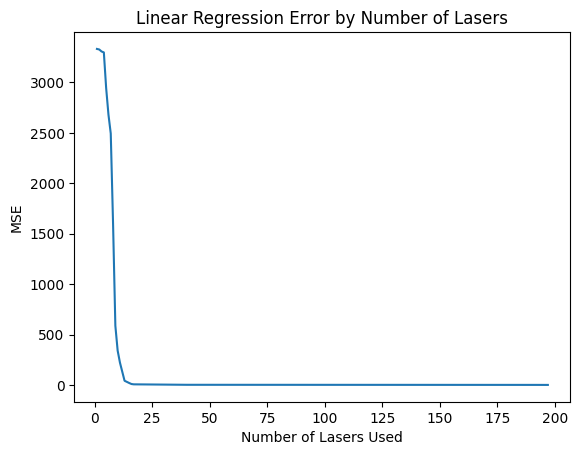

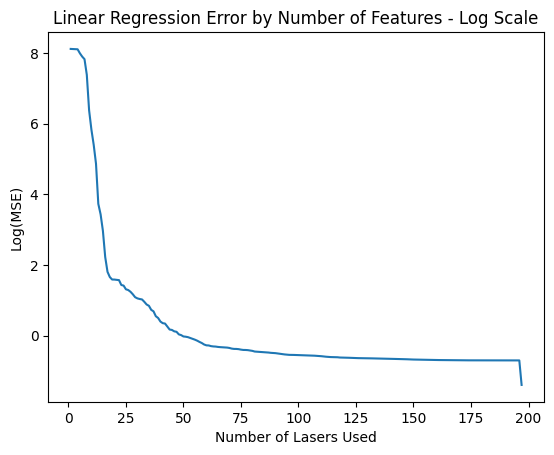

In [117]:
plt.plot(np.arange(197, 0, -1), errors)
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")
plt.title("Linear Regression Error by Number of Lasers")
plt.show()

plt.plot(np.arange(197, 0, -1), np.log(errors))
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")
plt.title("Linear Regression Error by Number of Features - Log Scale")
plt.show()

## Calculate Out of Sample MSE

In [40]:
outSampleMSE = []
for model in models_list:
    n_features = len(model.coef_)
    remaining = [i for i in range(197) if i not in removed_lasers[:197 - n_features]]

    outSampleMSE.append(calcMSE(model, X_test_norm[:, remaining], Y_test_raw, Y))

Text(0, 0.5, 'MSE')

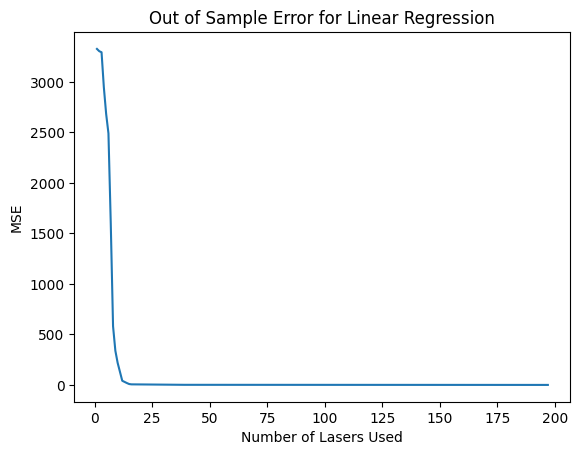

In [41]:
plt.plot(np.arange(197, 0, -1), outSampleMSE)
plt.title("Out of Sample Error for Linear Regression")
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")

Text(0, 0.5, 'Log(MSE)')

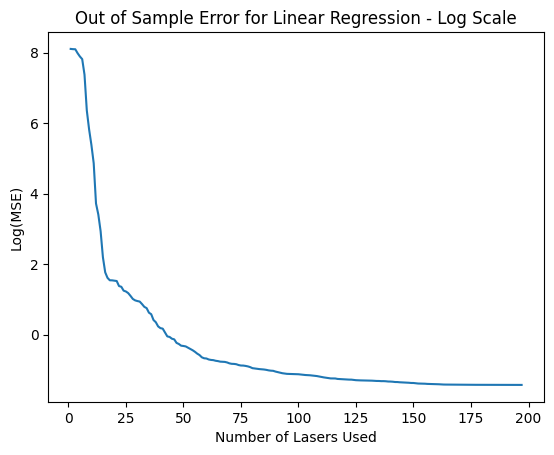

In [42]:
plt.plot(np.arange(197, 0, -1), np.log(outSampleMSE))
plt.title("Out of Sample Error for Linear Regression - Log Scale")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

Text(0, 0.5, 'Log(MSE)')

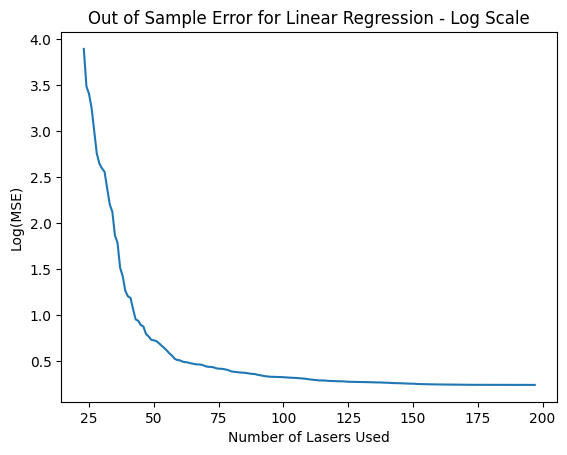

In [43]:
plt.plot(np.arange(MAX_LASERS, 22, -1), outSampleMSE[:175])
plt.title("Out of Sample Error for Linear Regression - Log Scale")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

# Create GIFS

## Imports

In [78]:
import imageio.v2 as imageio
import os

### Generate the intermediary gif frames points

In [44]:
coordinates = []
coordinate_colors = []
initial_colors = ["blue"] * MAX_LASERS

for i in range(MAX_LASERS):
    coefs = models_list[i].coef_
    if i < len(removed_lasers):
        initial_colors = initial_colors.copy()
        initial_colors[removed_lasers[i]] = "red"
        coordinate_colors.append(initial_colors)
    sorted_removed = sorted(removed_lasers[:i])
    for removed in sorted_removed:
        coefs = np.insert(coefs, removed, prev[removed])
    prev = coefs
    coordinates.append(coefs)

## Generate GIFs of weights

In [48]:
# frames between transitions
n_frames = 5
x = [i for i in range(197)]
coordinates_lists = coordinates
print('Creating charts\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
# for index in np.arange(0, 50):

    print("Coordinate", index+1, "/", len(coordinates_lists) - 1)
    # get current and next y coordinates
    y = coordinates_lists[index]
    y1 = coordinates_lists[index+1]
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        plt.bar(x, y_temp, color=coordinate_colors[index])
        plt.title("Coefficient Weights over Laser Removals")
        plt.xlabel("Laser Number")
        plt.ylabel("Feature Weight")
        plt.text(125, 0.9e8, "# Features:" + str(MAX_LASERS - index) + "\nRemoving Laser #" + str(removed_lasers[index]))
        # plt.figure(figsize=(14,7))
        plt.ylim(-1.2e8,1.2e8)
        # build file name and append to list of file names
        filename = f'gif_img/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(2):
                filenames.append(filename)
        # save img
        plt.savefig(filename)
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('mybars3.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')


Creating charts

Coordinate 1 / 196


ValueError: operands could not be broadcast together with shapes (198,) (197,) 

## Generate GIF of abs(weights)

In [25]:
# frames between transitions
n_frames = 5
x = [i for i in range(197)]
coordinates_lists = np.abs(coordinates)
print('Creating charts\n')
filenames = []
for index in np.arange(0, len(coordinates_lists)-1):
# for index in np.arange(0, 50):

    # print("Coordinate", index+1, "/", len(coordinates_lists) - 1)
    # get current and next y coordinates
    y = coordinates_lists[index]
    y1 = coordinates_lists[index+1]
    
    # calculate the distance to the next position
    y_path = np.array(y1) - np.array(y)
    for i in np.arange(0, n_frames + 1):
        # divide the distance by the number of frames 
        # and multiply it by the current frame number
        y_temp = (y + (y_path / n_frames) * i)
        # plot
        plt.bar(x, y_temp, color=coordinate_colors[index])
        plt.title("Coefficient Weights over Laser Removals")
        plt.xlabel("Laser Number")
        plt.ylabel("Feature Weight")
        plt.text(125, 0.9e8, "# Features:" + str(MAX_LASERS - index) + "\nRemoving Laser #" + str(removed_lasers[index]))
        # plt.figure(figsize=(14,7))
        plt.ylim(0,1.2e8)
        # build file name and append to list of file names
        filename = f'gif_img/frame_{index}_{i}.png'
        filenames.append(filename)
        # last frame of each viz stays longer
        if (i == n_frames):
            for i in range(2):
                filenames.append(filename)
        # save img
        plt.savefig(filename)
        plt.close()
print('Charts saved\n')
# Build GIF
print('Creating gif\n')
with imageio.get_writer('mybars4.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')


Creating charts



/var/folders/fw/lrzjsgg97bd8nh37fd2j0ygr0000gn/T/ipykernel_73422/1587189284.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates_lists = np.abs(coordinates)


ValueError: operands could not be broadcast together with shapes (198,) (197,) 

## Generate multi-graphs of errors

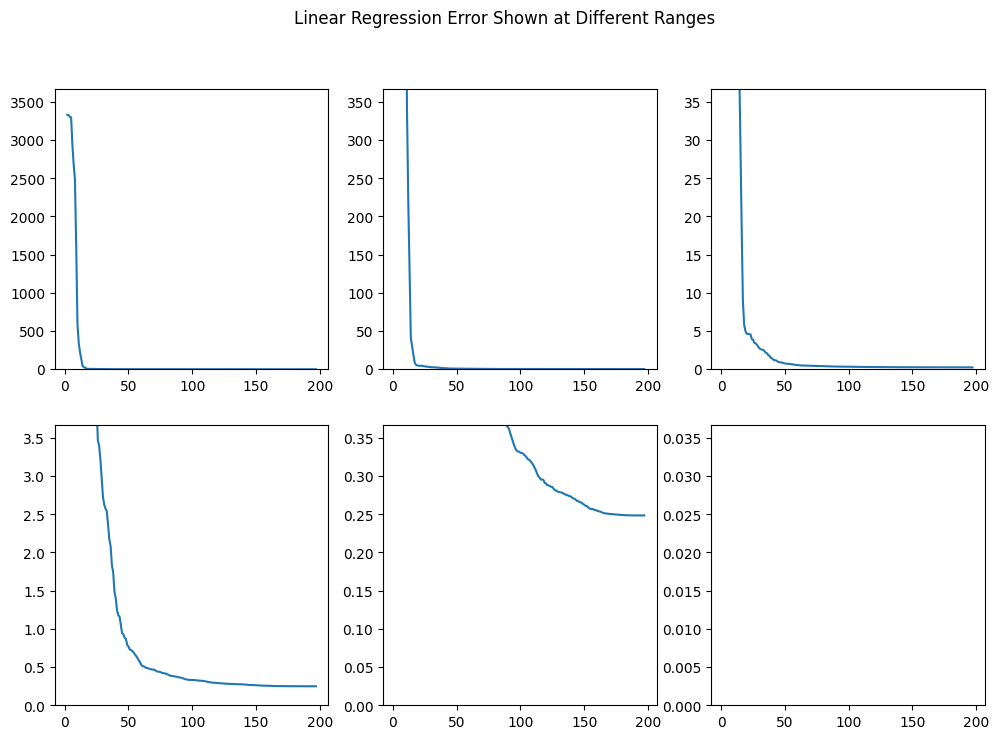

In [411]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, 1, -1), errors)
        ax[row, col].set_ylim(0, np.max(errors) * 1.1 / (10 ** count))
        count += 1

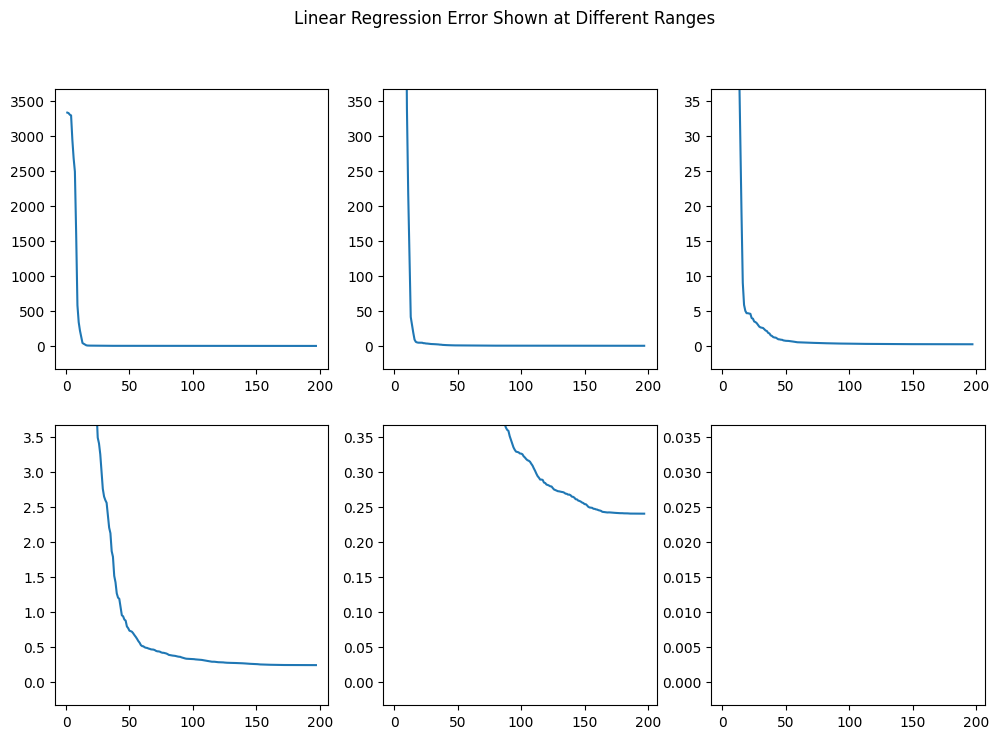

In [431]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, 0, -1), outSampleMSE)
        ax[row, col].set_ylim(-np.max(outSampleMSE) * .1 / (10 ** count), np.max(outSampleMSE) * 1.1 / (10 ** count))
        count += 1

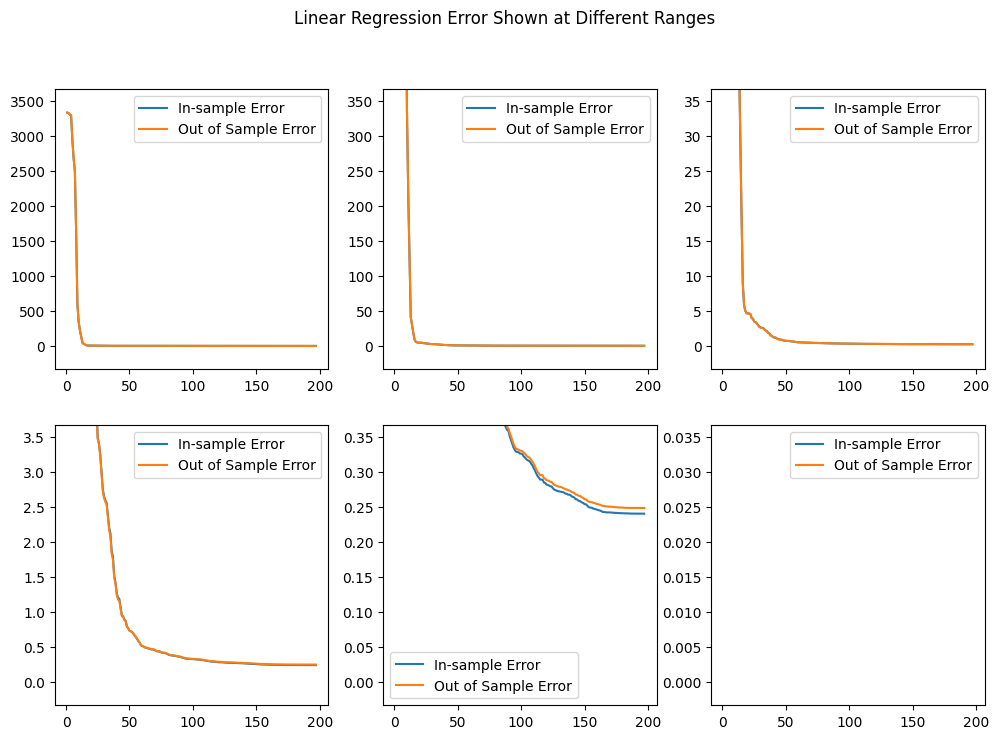

In [483]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges")

count = 0
for row in range(rows):
    for col in range(cols):
        l1 = ax[row, col].plot(np.arange(197, 0, -1), outSampleMSE, label="In-sample Error")
        l2 = ax[row, col].plot(np.arange(197, 0, -1), errors, label="Out of Sample Error")

        ax[row, col].set_ylim(-np.max(outSampleMSE) * .1 / (10 ** count), np.max(outSampleMSE) * 1.1 / (10 ** count))
        count += 1

        ax[row, col].legend()

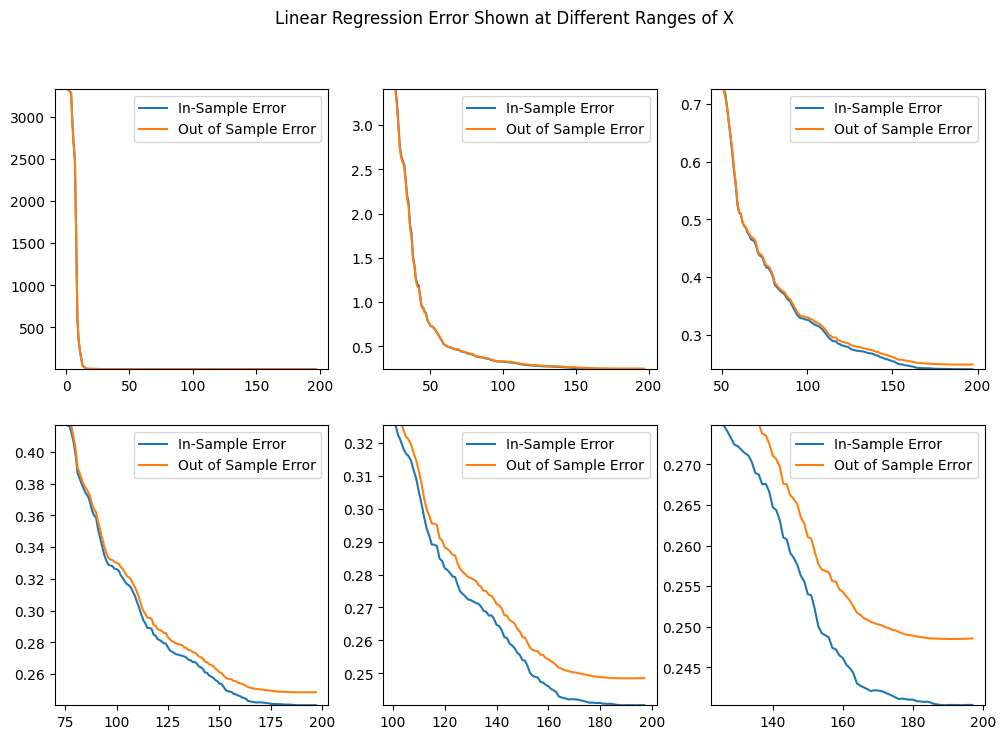

In [486]:
rows, cols = 2, 3
fig, ax = plt.subplots(rows, cols, figsize=(12,8))
fig.suptitle("Linear Regression Error Shown at Different Ranges of X")

count = 0
for row in range(rows):
    for col in range(cols):
        ax[row, col].plot(np.arange(197, count * 25, -1), outSampleMSE[:MAX_LASERS - count * 25], label="In-Sample Error")
        ax[row, col].plot(np.arange(197, count * 25, -1), errors[:MAX_LASERS - count * 25], label="Out of Sample Error")
        ax[row, col].legend()
        ax[row, col].set_ylim(np.min(outSampleMSE[:MAX_LASERS - count * 25]), np.max(outSampleMSE[:MAX_LASERS - count * 25]))
        count += 1

In [247]:
np.random.seed(2022)

In [256]:
order = [i for i in range(-3, -9, -1)]
for n in order:
    noisy_X_train = np.random.normal(0, 10 ** n, X.shape) + X
    noisy_X_train_norm = (noisy_X_train - noisy_X_train.mean(axis=0))/noisy_X_train.std(axis=0)

    noisy_models_list = []
    noisy_errors = []
    for i in range(MAX_LASERS):
        res, reg = trainSubset(noisy_X_train_norm, Y_train_norm, removed_lasers[:i], LinearRegression, mean_squared_error, graph=False)
        noisy_models_list.append(deepcopy(reg))
        noisy_errors.append(res)

    np.save("noisy_error_order_" + str(n) + ".npy", noisy_errors)
    save_models(noisy_models_list, "linear_reg_models/noisy_lin_reg_order_" + str(n))

-3
-4
-5
-6
-7
-8


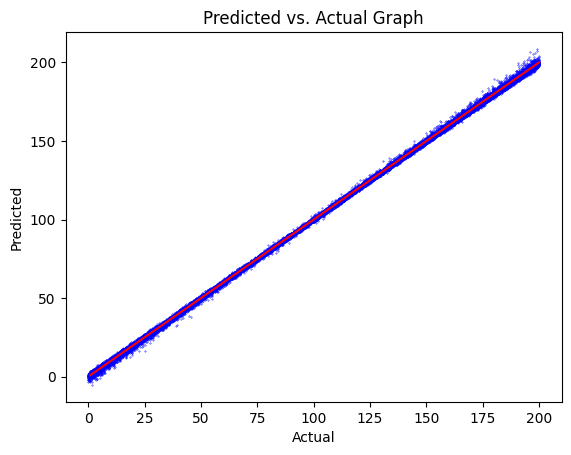

In [245]:
base_noisy_mse, base_noisy_model = train_with_CV(noisy_X_train_norm, Y_train_norm, LinearRegression, mean_squared_error, graph=True, norm=False)

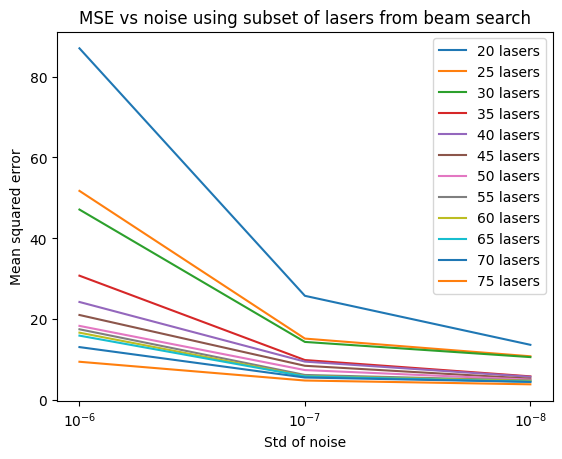

In [202]:
for i in range(len(num_lasers[2:])):
    temp = []
    for n in order[6:]:
        # models_loaded = load_models(["noisy_lin_reg_order_" + str(n) + "_removed_" + str(MAX_LASERS - i)] for i in num_lasers)
        errors_loaded = np.load("noisy_error_order_" + str(n) + ".npy")
        temp.append(errors_loaded[i + 2])
    plt.plot([("$10^{%d}$" % i)for i in order[6:]], temp)
    plt.xlabel("Std of noise")
    plt.ylabel("Mean squared error")
    plt.title("MSE vs noise using subset of lasers from beam search")
plt.legend([str(i) + " lasers" for i in num_lasers[2:]])

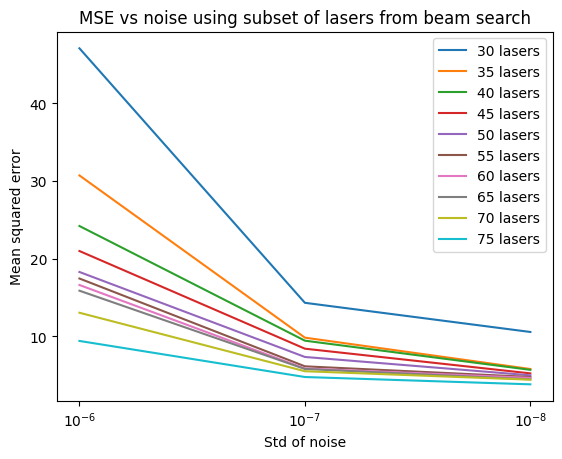

In [203]:
for i in range(len(num_lasers[4:])):
    temp = []
    for n in order[6:]:
        # models_loaded = load_models(["noisy_lin_reg_order_" + str(n) + "_removed_" + str(MAX_LASERS - i)] for i in num_lasers)
        errors_loaded = np.load("noisy_error_order_" + str(n) + ".npy")
        temp.append(errors_loaded[i + 4])
    plt.plot([("$10^{%d}$" % i)for i in order[6:]], temp)
    plt.xlabel("Std of noise")
    plt.ylabel("Mean squared error")
    plt.title("MSE vs noise using subset of lasers from beam search")
plt.legend([str(i) + " lasers" for i in num_lasers[4:]])


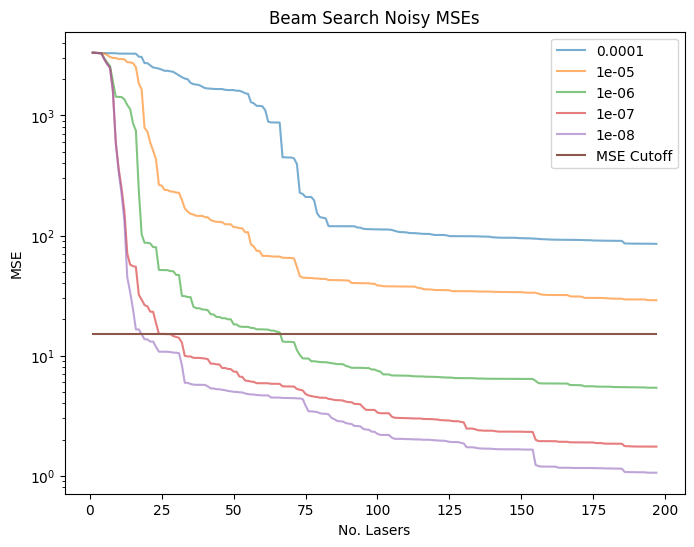

In [271]:
import matplotlib.pyplot as plt

intersect = []
plt.figure(figsize=(8,6)) 

for i in order[1:]:
  noisy_error = np.load("noisy_error_order_%d.npy" % i)
  plt.plot(range(197, 0, -1), noisy_error, alpha=0.6)
plt.title("Beam Search Noisy MSEs")
plt.xlabel("No. Lasers")
plt.ylabel("MSE")
plt.plot(range(1, 198), [15] * 197)
plt.yscale("log")
plt.legend([str(i) for i in [10 ** i for i in order[1:]]] + ["MSE Cutoff"])
plt.show()

# Float32 Beam Search

In [15]:
from time import time

Z_raw = pd.read_parquet("./data/test_regression.parquet")
Z_test_raw = np.array(Z_raw, dtype=np.float32)

X_test_32_raw = Z_test_raw[:,:-1]
Y_test_32_raw = Z_test_raw[:, -1]

## Normalize data

In [38]:
np.random.seed(2022)
order = -5

Z_train_32_raw = pd.read_parquet("./data/train_regression.parquet")
Z_train_32_raw = Z_train_32_raw.to_numpy(dtype=np.float32)
np.random.shuffle(Z_train_32_raw)
X_train_32_raw = Z_train_32_raw[:,:-1]
Y_train_32_raw = Z_train_32_raw[:, -1]

Z_test_32_raw = pd.read_parquet("./data/test_regression.parquet")
Z_test_32_raw = np.array(Z_raw, dtype=np.float32)
X_test_32_raw = Z_test_32_raw[:,:-1]
Y_test_32_raw = Z_test_32_raw[:, -1]

X_train_32_raw_noisy = np.random.normal(0, 10 ** order, X_train_32_raw.shape) + X_train_32_raw
X_test_32_raw_noisy = np.random.normal(0, 10 ** order, X_test_32_raw.shape) + X_test_32_raw

X_train_32_norm, X_test_32_norm, Y_test_32_norm = normalize(X_train_32_raw, X_test_32_raw, Y_train_32_raw)
X_train_32_norm_noisy, X_test_32_norm_noisy, Y_train_32_norm = normalize(X_train_32_raw_noisy, X_test_32_raw_noisy, Y_train_32_raw)

## Baseline

### Baseline No Noise

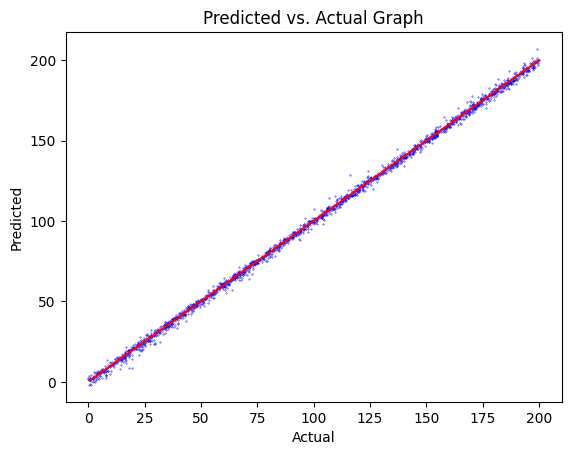

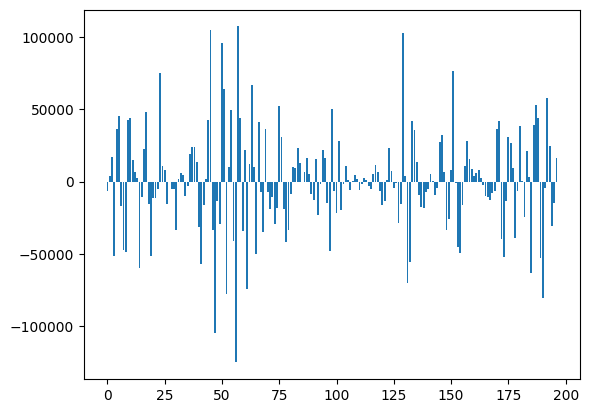

MSE:  3.2120385


In [349]:
base_mse_32, base_model_32 = train_with_CV(X_train_32_norm, Y_train_32_raw, LinearRegression, mean_squared_error)
showWeightPlot(base_model_32)
print("MSE: ", base_mse_32)

### Baseline with Noise

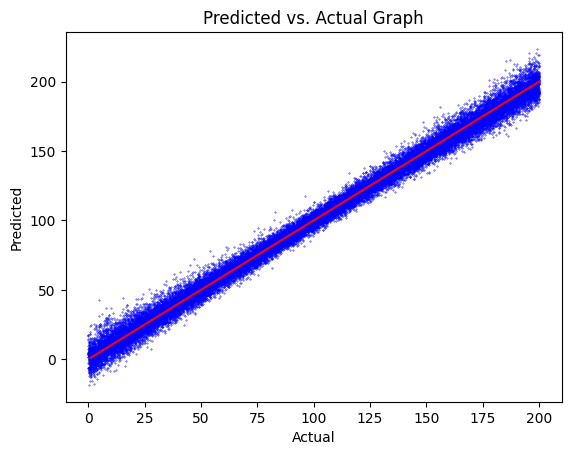

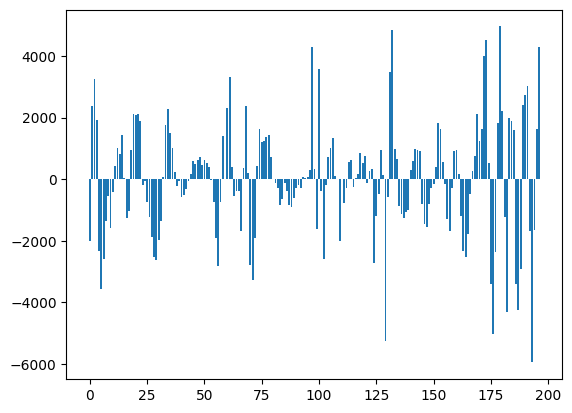

MSE:  29.012239967271107


In [46]:
base_mse_32, base_model_32 = train_with_CV(X_train_32_norm_noisy, Y_train_32_raw, LinearRegression, mean_squared_error)
showWeightPlot(base_model_32)
print("MSE: ", base_mse_32)

## Backwards Beam Search with no noise (float32)

In [285]:
np.random.seed(2022)

In [353]:
lasers = set([i for i in range(MAX_LASERS)])
removed_lasers_32 = []
errors_32 = []
models_32 = []

for i in range(MAX_LASERS-1):
    start1 = time()
    print("Starting Round:", i+1, "/", MAX_LASERS)
    best_mse = float('inf')
    best_reg = None
    removed_index = -1
    count = 1
    for j in lasers:
        start2 = time()
        print("\tPerforming regression", count, "/", len(lasers), "of run #", i+1)
        count += 1
        curr_mse, curr_reg = trainSubset(X_train_32_norm, Y_train_32_raw, removed_lasers_32 +  [j],LinearRegression, mean_squared_error, graph=False)
        if curr_mse < best_mse:
            best_mse, best_reg = curr_mse, curr_reg
            removed_index = j
        end2 = time()
        print("\t\t", end2 - start2, "s")
    end1 = time()
    print("\t", end1 - start1, "s")

    removed_lasers_32.append(removed_index)
    lasers.remove(removed_index)
    errors_32.append(best_mse)
    models_32.append(deepcopy(curr_reg))

Starting Round: 1 / 197
	Performing regression 1 / 197 of run # 1
		 1.5341718196868896 s
	Performing regression 2 / 197 of run # 1
		 1.6024739742279053 s
	Performing regression 3 / 197 of run # 1
		 2.349536180496216 s
	Performing regression 4 / 197 of run # 1
		 1.5792429447174072 s
	Performing regression 5 / 197 of run # 1
		 1.621833086013794 s
	Performing regression 6 / 197 of run # 1
		 1.6290831565856934 s
	Performing regression 7 / 197 of run # 1
		 1.6418251991271973 s
	Performing regression 8 / 197 of run # 1
		 1.6452529430389404 s
	Performing regression 9 / 197 of run # 1
		 1.5897908210754395 s
	Performing regression 10 / 197 of run # 1
		 1.686448097229004 s
	Performing regression 11 / 197 of run # 1
		 1.5238831043243408 s
	Performing regression 12 / 197 of run # 1
		 1.6406352519989014 s
	Performing regression 13 / 197 of run # 1
		 1.6001038551330566 s
	Performing regression 14 / 197 of run # 1
		 1.6546058654785156 s
	Performing regression 15 / 197 of run # 1
		 1.56

### Save results

In [357]:
np.save('errors_32.npy', errors_32)
np.save('removed_lasers_32.npy', removed_lasers_32)

### Load Results

In [11]:
error_32 = np.load('errors_32.npy')
removed_lasers_32 = np.load('removed_lasers_32.npy')

### Save Models

In [ ]:
for i in range(1, 198):
    print(i)
    dump(models_32[i-1], 'linear_reg_models/removed_' + str(i) + '_32.joblib') 

### Plot error graphs

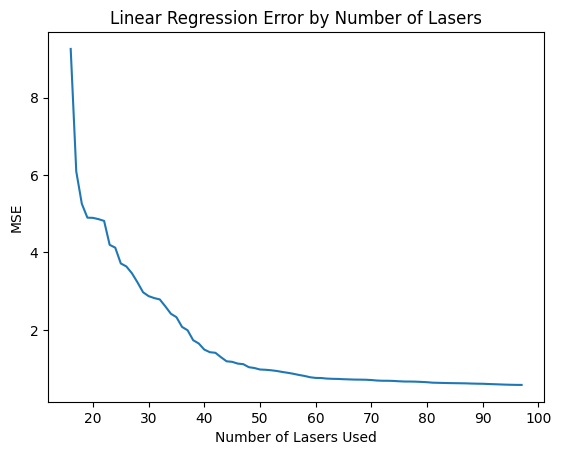

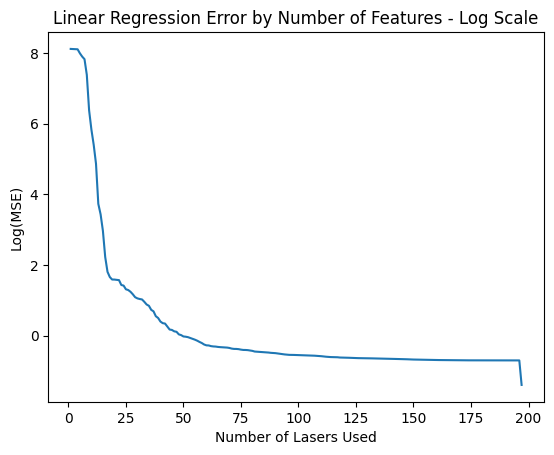

In [371]:
plt.plot(np.arange(197, 0, -1)[100:-15], errors[100:-15])
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")
plt.title("Linear Regression Error by Number of Lasers")
plt.show()

plt.plot(np.arange(197, 0, -1), np.log(errors))
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")
plt.title("Linear Regression Error by Number of Features - Log Scale")
plt.show()

### Regenerating models and obtaining OOS MSE

In [364]:
models_list_32 = []
errors_32_regen = []
outSampleMSE_32 = []

for i in range(MAX_LASERS):
    res, reg = trainSubset(X_train_32_norm, Y_train_32_raw, removed_lasers_32[:i], LinearRegression, mean_squared_error, graph=False)

    n_features = len(reg.coef_)
    remaining = [i for i in range(197) if i not in removed_lasers_32[:197 - n_features]]
    outSampleMSE_32.append(calcMSE(model, X_test_32_norm[:, remaining], Y_test_32_raw, Y_train_32_raw))
    
    models_list_32.append(deepcopy(reg))
    errors_32_regen.append(res)

In [362]:
outSampleMSE_32 = []
for model in models_list_32:
    n_features = len(model.coef_)
    remaining = [i for i in range(197) if i not in removed_lasers_32[:197 - n_features]]

    outSampleMSE_32.append(calcMSE(model, X_test_32_norm[:, remaining], Y_test_32_raw, Y_train_32_raw))

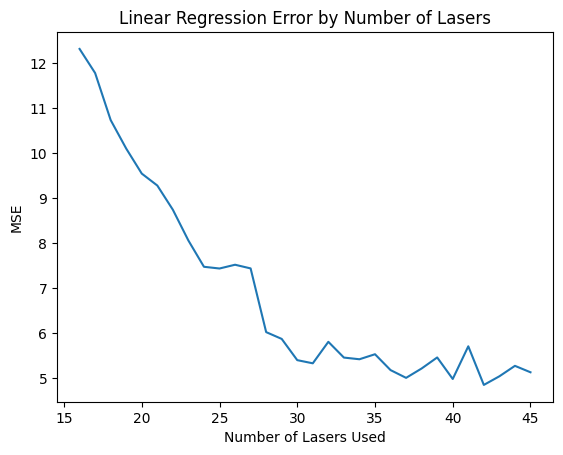

In [385]:
plt.plot(np.arange(197, 0, -1)[-45:-15], errors_32_regen[-45:-15])
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")
plt.title("Linear Regression Error by Number of Lasers")
plt.show()

Text(0, 0.5, 'Log(MSE)')

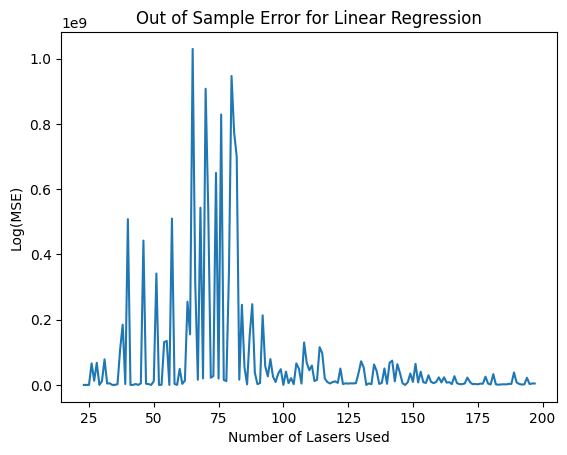

In [381]:
plt.plot(np.arange(MAX_LASERS, 22, -1), outSampleMSE_32[:175])
plt.title("Out of Sample Error for Linear Regression")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

## Noisy Backwards Beam Search (float32)

In [397]:
order = -5
noisy_X_train_32_raw = np.random.normal(0, 10 ** order, X_train_32_raw.shape) + X_train_32_raw
noisy_X_train_32_norm = (noisy_X_train_32_raw - noisy_X_train_32_raw.mean(axis=0))/noisy_X_train_32_raw.std(axis=0)

In [ ]:
lasers = set([i for i in range(MAX_LASERS)])
removed_lasers_32_noisy = []
errors_32_noisy = []
models_32_noisy = []

for i in range(MAX_LASERS-1):
    start1 = time()
    # print("Starting Round:", i+1, "/", MAX_LASERS)
    best_mse = float('inf')
    best_reg = None
    removed_index = -1
    count = 1
    for j in lasers:
        # start2 = time()
        # print("\tPerforming regression", count, "/", len(lasers), "of run #", i+1)
        count += 1
        curr_mse, curr_reg = trainSubset(noisy_X_train_32_norm, Y_train_32_raw, removed_lasers_32_noisy +  [j],LinearRegression, mean_squared_error, graph=False)
        if curr_mse < best_mse:
            best_mse, best_reg = curr_mse, curr_reg
            removed_index = j
        # end2 = time()
        # print("\t\t", end2 - start2, "s")

    removed_lasers_32_noisy.append(removed_index)
    lasers.remove(removed_index)
    errors_32_noisy.append(best_mse)
    models_32_noisy.append(deepcopy(best_reg))

    end1 = time()
    print("-" * 20)
    print(end1 - start1, "s")
    print("Linear Regression #%d" % (i + 1))
    print("Removing laser index %d" % (removed_index))
    print("Validation Error %f" % (best_mse))
    print("_" * 20)



In [47]:
np.save("removed_lasers_32_noisy.npy", removed_lasers_32_noisy)
np.save("errors_32_noisy.npy", errors_32_noisy)

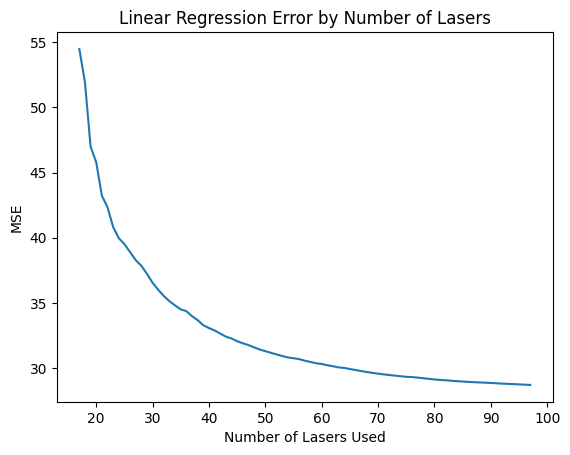

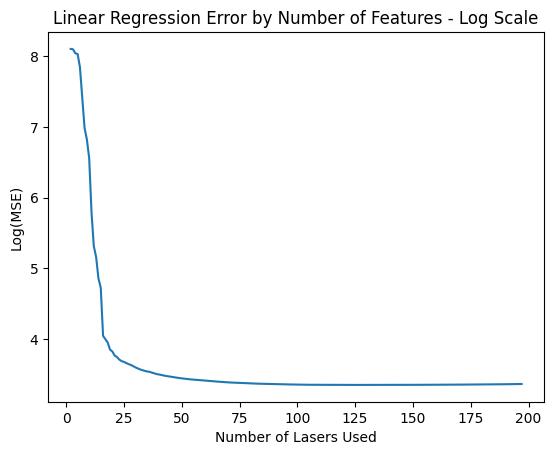

In [407]:
plt.plot(np.arange(197, 1, -1)[100:-15], errors_32_noisy[100:-15])
plt.xlabel("Number of Lasers Used")
plt.ylabel("MSE")
plt.title("Linear Regression Error by Number of Lasers")
plt.show()

plt.plot(np.arange(197, 1, -1), np.log(errors_32_noisy))
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")
plt.title("Linear Regression Error by Number of Features - Log Scale")
plt.show()

### OOS MSE

In [453]:
n_features = [20, 30, 40, 50, 60, 70]
outSampleMSE_32 = []
outSampleMSE_32_noisy = []
inSample_32 = []
inSample_32_noisy = []

for n in range(1, MAX_LASERS):
    remaining = [i for i in range(197) if i not in removed_lasers_32[:197 - n]]
    
    res, reg = train_with_CV(X_train_32_norm[:, remaining], Y_train_32_raw, LinearRegression, mean_squared_error, graph=False)
    inSample_32.append(res)
    outSampleMSE_32.append(calcMSE(reg, X_test_32_norm[:, remaining], Y_test_32_raw, Y_train_32_raw))

    res, reg = train_with_CV(X_train_32_norm_noisy[:, remaining], Y_train_32_raw, LinearRegression, mean_squared_error, graph=False)
    inSample_32_noisy.append(res)
    outSampleMSE_32_noisy.append(calcMSE(reg, X_test_32_norm_noisy[:, remaining], Y_test_32_raw, Y_train_32_raw))


In [ ]:
n_features = [20, 30, 40, 50, 60, 70]
for n in n_features:
    print(outSampleMSE_32[n - 1])
print()
for n in n_features:
    print(outSampleMSE_32_noisy[n - 1])

Text(0, 0.5, 'Log(MSE)')

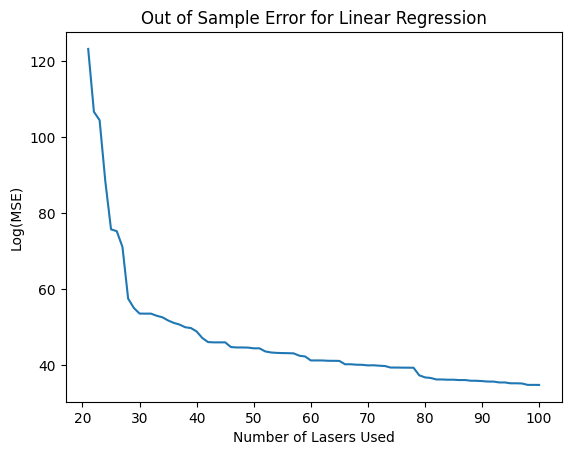

In [468]:
plt.plot(np.arange(1, 197)[20:100], outSampleMSE_32_noisy[20:100])
plt.title("Out of Sample Error for Linear Regression")
plt.xlabel("Number of Lasers Used")
plt.ylabel("Log(MSE)")

### Quadratic Ridge Regression with Beam Search Indices

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

n_features = [20]
degrees = [2]
alpha = [0]

_x_train_32_norm_noisy, _x_val_32_norm_noisy, _y_train_32_raw_, _y_val_32_raw = train_test_split(X_train_32_norm_noisy, Y_train_32_raw, test_size=0.2)
for n in n_features:
    remaining = [i for i in range(MAX_LASERS) if i not in removed_lasers_32_noisy[:-(n-1)]]
    for d in degrees:
        for a in alpha:
            poly = PolynomialFeatures(d, include_bias=False)
            X_train = poly.fit_transform(_x_train_32_norm_noisy[:, remaining])
            X_valid = poly.fit_transform(_x_val_32_norm_noisy[:, remaining])
            X_test  = poly.fit_transform(X_test_32_norm_noisy[:, remaining])

            reg = Ridge(alpha=a).fit(X_train, _y_train_32_raw_)
            train_mse = mean_squared_error(reg.predict(X_train), _y_train_32_raw_)
            valid_mse = mean_squared_error(reg.predict(X_valid), _y_val_32_raw)
            test_mse  = mean_squared_error(reg.predict(X_test),  Y_test_32_raw)
            print(f'num lasers = {n}')
            print(f'alpha = {a}')
            print(f'degree = {d}')
            print(f'train mse = {train_mse}')
            print(f'valid mse = {valid_mse}')
            print(f'test mse = {test_mse}')
            print('-' * 75)
